# Parte 2: Clasificación con ANN 

Observamos overfitting en la gráfica. Además:
    
    loss = 0.01
    accuracy = 0.999 
    val_loss = 2.09
    val_accuracy = 0.68
    
Por tanto: 

    Etrain = 1-0.999 = 0.001
    Etest = 1- 0.68 = 0.32
    
    Bias = Etrain - Ehuman = 0.001
    Variance = Etest - Etrain = 0.32 - 0.001 = 0.319

Observamos que hay un bajo bias pero una alta varianza: podemos regularizar, cambiar la arquitectura, añadir más datos...

Se ha probado con , kernel_regularizer = keras.regularizers.l1_l2(0.001) pero ha tenido un mal resultado.
Se ha añadido Dropout(rate = rate_dropout[i]) rate_dropout = [0.8, 0.4, 0.2, 0.1]
Así: 

    loss = 0.345817
    accuracy = 0.868716 
    val_loss = 0.85344
    val_accuracy = 0.688326
    
Por tanto: 

    Etrain = 1 - 0.868716  = 0.13
    Etest = 1 - 0.688326 = 0.31
    
    Bias = Etrain - Ehuman = 0.13
    Variance = Etest - Etrain = 0.31 - 0.13 = 0.18
    
El bias vuelve a estar alto (13%)
			

### 1 - Import Libraries

In [2]:
# Tensorflow and tf.keras
import tensorflow as tf
from tensorflow import keras

#Helper libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


### 2 - Load data

In [3]:
class ROutput:
    def __init__(self, task, data):
        self.task = task
        self.data = data
        
class OutTaskData: 
    def __init__(self, task, data): 
        self.task = task
        self.data = data

In [4]:
import scipy.io as sio
# Primero leemos los registros
def read_outputs(rec):
    '''read_outputs("userS0091f1.mat")'''
    mat = sio.loadmat(rec)
    #mdata = mat['output']
    #val = mdata[0,0]
    #output = ROutput(np.array(val["task"]), np.array(val["data"]))
    output = ROutput(np.array(mat["task"]), np.array(mat["data"]))
    return output

In [15]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Perceptron

total_records = 4 # CAMBIAR SI HAY MAS REGISTROS

task1 = 122 # SE PUEDE CAMBIAR
task2 = 123 # SE PUEDE CAMBIAR
task3 = 127 # SE PUEDE CAMBIAR
user = '0091' # SE PUEDE CAMBIAR

lTaskData = []
for i_rec in range(1,total_records+1):
        record = "userS"+user+"f"+str(i_rec)+".mat"
        output = read_outputs(record) # output.task será y, output.data será x
        
        if task3 != "":
            outT = (output.task == task1) | (output.task == task2) | (output.task == task3) 
        else: 
            outT = (output.task == task1) | (output.task == task2)
        
        outData = output.data[outT[:,0],0:np.shape(output.data)[1]]
        outTask = output.task[outT[:,0]]
        outTD = OutTaskData(outTask, outData)
        lTaskData.append(outTD)
        print(np.shape(outTD.data), np.shape(outTD.task))
print(np.shape(lTaskData))
# Vamos a coger 2 registros para el entrenamiento, 1 para el conjunto dev set, 1 para el test set
X_train, y_train, X_dev, y_dev = [],[],[],[] 
for j in range(0,total_records-2): # Cogemos 2 registros para entrenamiento
    X_train.extend(lTaskData[j].data)
    print ("HOLAAAAX_train:",np.shape(X_train))
    y_train.extend(lTaskData[j].task)
    
X_dev.extend(lTaskData[total_records-2].data) # Cogemos un registro para el dev set
y_dev.extend(lTaskData[total_records-2].task)

X_train = np.array(X_train)
y_train = np.ravel(np.array(y_train))
X_dev = np.array(X_dev)
y_dev = np.ravel(np.array(y_dev))

print ("X_train:",X_train.shape)
print ("y_train:",y_train.shape)

print ("X_dev:",X_dev.shape)
print ("y_dev:",y_dev.shape)

# ONE HOT ENCODER
encoder = make_pipeline(StandardScaler(), OneHotEncoder(categories="auto", sparse=False)) # Function that one-hot encodes integers))
y_one_hot = np.concatenate((y_train, y_dev), axis=0)
y_one_hot = encoder.fit_transform (y_one_hot.reshape(-1,1))
y_train = y_one_hot[:np.shape(y_train)[0]]
y_dev = y_one_hot[np.shape(y_train)[0]:]

print("ONE HOT ENCODER:")
print ("X_train:",X_train.shape)
print ("y_train:",y_train.shape)

print ("X_dev:",X_dev.shape)
print ("y_dev:",y_dev.shape)


X_test, y_test = [],[]
X_test.extend(lTaskData[total_records-1].data) # Cogemos un registro para el test set
y_test.extend(lTaskData[total_records-1].task)


X_test = np.array(X_test)
y_test = np.ravel(np.array(y_test))
print()
print ("X_test:",X_test.shape)
print ("y_test:",y_test.shape)

# ONE HOT ENCODER
encoder = make_pipeline(StandardScaler(), OneHotEncoder(categories="auto", sparse=False)) # Function that one-hot encodes integers))
y_test = encoder.fit_transform (y_test.reshape(-1,1)) # y_one_hot

print("ONE HOT ENCODER:")
print ("X_test:",X_test.shape)
print ("y_test:",y_test.shape)
    

(919, 96) (919, 1)
(918, 96) (918, 1)
(928, 96) (928, 1)
(908, 96) (908, 1)
(4,)
HOLAAAAX_train: (919, 96)
HOLAAAAX_train: (1837, 96)
X_train: (1837, 96)
y_train: (1837,)
X_dev: (928, 96)
y_dev: (928,)
ONE HOT ENCODER:
X_train: (1837, 96)
y_train: (1837, 3)
X_dev: (928, 96)
y_dev: (928, 3)

X_test: (908, 96)
y_test: (908,)
ONE HOT ENCODER:
X_test: (908, 96)
y_test: (908, 3)


### 3. Initialize variables

In [6]:
INPUTS = X_train.shape[1]
OUTPUTS = y_train.shape[1]
NUM_TRAINING_EXAMPLES = int(round(X_train.shape[0]/1))
NUM_DEV_EXAMPLES = int(round(y_train.shape[0]/1))

Some data is displayed to test correctness:

In [7]:
X_train[:2]

array([[0.04408895, 0.12253977, 0.04091295, 0.08794782, 0.15217319,
        0.13608194, 0.2390196 , 0.13782482, 0.09390321, 0.04168143,
        0.01182343, 0.06681896, 0.22746509, 0.19109141, 0.12382088,
        0.16280571, 0.18183189, 0.03489224, 0.08915041, 0.25065591,
        0.05125344, 0.00878363, 0.06399049, 0.01269724, 0.37617251,
        0.75052793, 1.22515657, 0.34716337, 0.57574146, 0.22845317,
        0.29124432, 1.55810067, 0.17399072, 0.23187383, 0.09419699,
        0.06491878, 0.21030758, 0.11561159, 0.00684065, 0.05363316,
        0.14742724, 0.20516924, 0.16582891, 0.39129693, 0.01763402,
        0.05230747, 0.08436656, 0.05071257, 0.56726584, 0.21727165,
        0.5006733 , 0.09225466, 0.35750867, 0.43229655, 0.32666971,
        1.18042048, 0.04529925, 0.07339755, 0.12920241, 0.0228346 ,
        0.65176526, 0.09837585, 0.10240039, 0.35185881, 0.26348807,
        1.00112018, 0.61259061, 0.26154294, 0.2272173 , 0.11858029,
        0.23408875, 0.139735  , 0.43931357, 0.19

In [8]:
X_dev[:2]

array([[0.31977337, 0.34138627, 0.05036713, 0.01260456, 0.0353549 ,
        0.1185597 , 0.0467738 , 0.02048903, 0.11750225, 0.18469527,
        0.07158117, 0.04380819, 0.12918097, 0.15723066, 0.02486799,
        0.03569243, 0.13103253, 0.06666701, 0.12041935, 0.114042  ,
        0.01127984, 0.00650994, 0.05578655, 0.03110349, 1.27905692,
        0.72867136, 0.16631234, 0.39783501, 0.3504427 , 0.14931918,
        0.27219299, 0.119918  , 0.26639091, 0.05500265, 0.22028407,
        0.02976071, 0.49903653, 0.47147668, 0.21772425, 0.09625628,
        0.07949809, 0.07850754, 0.11222314, 0.0312656 , 0.0638701 ,
        0.01024857, 0.20098298, 0.12413927, 0.7959434 , 0.33244281,
        0.10382577, 0.36052956, 0.10868066, 0.25468323, 0.25108932,
        0.10744763, 0.22111074, 0.06949752, 0.22837273, 0.09663771,
        2.78278246, 0.95993224, 0.68951591, 0.5680906 , 0.29189192,
        0.02141107, 0.20762499, 0.11463274, 0.26281785, 0.02967406,
        0.25185108, 0.18281109, 1.13036793, 0.22

In [11]:
y_train[:2]

array([[0., 0., 1.],
       [0., 0., 1.]])

In [12]:
y_dev[:2]

array([[0., 1., 0.],
       [0., 1., 0.]])

### 4 - Set hyperparameters

In [13]:
n_epochs = 2000
learning_rate = 0.001
batch_size = 250 
n_neurons_per_hlayer = [500, 250, 75, 25] # Number of units per layer, 4 hidden layers
rate_dropout = [0.8, 0.4, 0.2, 0.1]

### 5 - Build the model: 96-500-250-75-25-3 deep neural network architecture

In [14]:
model = keras.Sequential(name="DeepFeedforward")

model.add(keras.layers.InputLayer(input_shape=(INPUTS,), batch_size=None))

i = 0
for neurons in n_neurons_per_hlayer:
    model.add(keras.layers.Dense(neurons, activation="relu", kernel_initializer="he_normal"))
    model.add(keras.layers.Dropout(rate = rate_dropout[i]))
    model.add(keras.layers.BatchNormalization())
    i+=1

model.add(keras.layers.Dense(OUTPUTS, activation="softmax"))
model.summary()

Model: "DeepFeedforward"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               48500     
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 500)               2000      
_________________________________________________________________
dense_1 (Dense)              (None, 250)               125250    
_________________________________________________________________
dropout_1 (Dropout)          (None, 250)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 250)               1000      
_________________________________________________________________
dense_2 (Dense)              (None, 75)            

In [15]:
model.layers

In [16]:
for l in model.layers: print (l.name)

dense
dropout
batch_normalization
dense_1
dropout_1
batch_normalization_1
dense_2
dropout_2
batch_normalization_2
dense_3
dropout_3
batch_normalization_3
dense_4


All the parameters of a layer can bee accessed:

In [17]:
weights, biases = model.layers[0].get_weights()
weights.shape

(96, 500)

In [18]:
weights

array([[-0.11124017, -0.09981345, -0.20696092, ...,  0.09139775,
        -0.29162315, -0.1004139 ],
       [-0.22626065, -0.03842637, -0.0311173 , ..., -0.09392659,
         0.03192707, -0.15312067],
       [ 0.24810904,  0.03769321, -0.05065431, ..., -0.15161228,
         0.04015096,  0.07852896],
       ...,
       [ 0.20723216,  0.09878181, -0.10826218, ...,  0.12538475,
         0.12597924,  0.0646811 ],
       [ 0.02549746, -0.09577837,  0.29207614, ..., -0.13750826,
         0.09046565,  0.0643509 ],
       [ 0.16807342, -0.0970289 , -0.0997621 , ..., -0.18232174,
        -0.11222138,  0.15767258]], dtype=float32)

In [19]:
biases # Bias de la primera capa: 500 bias inicializados a 0 

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [20]:
biases.shape

(500,)

### 6. Compile the model

In [21]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999),
              metrics=["categorical_accuracy"])


### 7. Train the model with M-BGD

In [22]:
import time
start = time.time()
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, verbose=1, validation_data=(X_dev, y_dev))    
print (time.time() - start)

Epoch 1/2000
8/8 [==============================] - 2s 113ms/step - loss: 1.4819 - categorical_accuracy: 0.3577 - val_loss: 1.0469 - val_categorical_accuracy: 0.4321
Epoch 2/2000
8/8 [==============================] - 0s 13ms/step - loss: 1.2517 - categorical_accuracy: 0.4244 - val_loss: 1.1107 - val_categorical_accuracy: 0.4784
Epoch 3/2000
8/8 [==============================] - 0s 13ms/step - loss: 1.1200 - categorical_accuracy: 0.4735 - val_loss: 1.1640 - val_categorical_accuracy: 0.5162
Epoch 4/2000
8/8 [==============================] - 0s 11ms/step - loss: 1.0609 - categorical_accuracy: 0.4984 - val_loss: 1.1674 - val_categorical_accuracy: 0.5259
Epoch 5/2000
8/8 [==============================] - 0s 11ms/step - loss: 1.0378 - categorical_accuracy: 0.5146 - val_loss: 1.1436 - val_categorical_accuracy: 0.5345
Epoch 6/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.9928 - categorical_accuracy: 0.5240 - val_loss: 1.1109 - val_categorical_accuracy: 0.5550
Epoch 7/2

8/8 [==============================] - 0s 17ms/step - loss: 0.5558 - categorical_accuracy: 0.7657 - val_loss: 0.7760 - val_categorical_accuracy: 0.7263
Epoch 100/2000
8/8 [==============================] - 0s 16ms/step - loss: 0.5709 - categorical_accuracy: 0.7606 - val_loss: 0.7686 - val_categorical_accuracy: 0.7252
Epoch 101/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.5638 - categorical_accuracy: 0.7629 - val_loss: 0.7605 - val_categorical_accuracy: 0.7328
Epoch 102/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.5480 - categorical_accuracy: 0.7685 - val_loss: 0.7546 - val_categorical_accuracy: 0.7403
Epoch 103/2000
8/8 [==============================] - 0s 16ms/step - loss: 0.5551 - categorical_accuracy: 0.7752 - val_loss: 0.7624 - val_categorical_accuracy: 0.7349
Epoch 104/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.5738 - categorical_accuracy: 0.7614 - val_loss: 0.7755 - val_categorical_accuracy: 0.7263
Epoch 105/200

8/8 [==============================] - 0s 11ms/step - loss: 0.4348 - categorical_accuracy: 0.8235 - val_loss: 0.9210 - val_categorical_accuracy: 0.6864
Epoch 198/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.4045 - categorical_accuracy: 0.8385 - val_loss: 0.9291 - val_categorical_accuracy: 0.6907
Epoch 199/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.3935 - categorical_accuracy: 0.8500 - val_loss: 0.9384 - val_categorical_accuracy: 0.7026
Epoch 200/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.3885 - categorical_accuracy: 0.8481 - val_loss: 0.9383 - val_categorical_accuracy: 0.7026
Epoch 201/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.4005 - categorical_accuracy: 0.8438 - val_loss: 0.9369 - val_categorical_accuracy: 0.7058
Epoch 202/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.4269 - categorical_accuracy: 0.8306 - val_loss: 0.9209 - val_categorical_accuracy: 0.7080
Epoch 203/200

8/8 [==============================] - 0s 11ms/step - loss: 0.3287 - categorical_accuracy: 0.8650 - val_loss: 1.0130 - val_categorical_accuracy: 0.6886
Epoch 296/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.3272 - categorical_accuracy: 0.8722 - val_loss: 1.0194 - val_categorical_accuracy: 0.6864
Epoch 297/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.3151 - categorical_accuracy: 0.8763 - val_loss: 1.0608 - val_categorical_accuracy: 0.6746
Epoch 298/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.2996 - categorical_accuracy: 0.8844 - val_loss: 1.0731 - val_categorical_accuracy: 0.6713
Epoch 299/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.3113 - categorical_accuracy: 0.8761 - val_loss: 1.0626 - val_categorical_accuracy: 0.6756
Epoch 300/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.3250 - categorical_accuracy: 0.8744 - val_loss: 1.0334 - val_categorical_accuracy: 0.6886
Epoch 301/200

8/8 [==============================] - 0s 11ms/step - loss: 0.2515 - categorical_accuracy: 0.9067 - val_loss: 1.1353 - val_categorical_accuracy: 0.6907
Epoch 394/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.2470 - categorical_accuracy: 0.9019 - val_loss: 1.1099 - val_categorical_accuracy: 0.7004
Epoch 395/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.2539 - categorical_accuracy: 0.8989 - val_loss: 1.0937 - val_categorical_accuracy: 0.7037
Epoch 396/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.2432 - categorical_accuracy: 0.9025 - val_loss: 1.1280 - val_categorical_accuracy: 0.6864
Epoch 397/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.2514 - categorical_accuracy: 0.9062 - val_loss: 1.1180 - val_categorical_accuracy: 0.6853
Epoch 398/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.2650 - categorical_accuracy: 0.9067 - val_loss: 1.0726 - val_categorical_accuracy: 0.6897
Epoch 399/200

8/8 [==============================] - 0s 12ms/step - loss: 0.2247 - categorical_accuracy: 0.9067 - val_loss: 1.1068 - val_categorical_accuracy: 0.7015
Epoch 492/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.2133 - categorical_accuracy: 0.9218 - val_loss: 1.1314 - val_categorical_accuracy: 0.6961
Epoch 493/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.2181 - categorical_accuracy: 0.9065 - val_loss: 1.1505 - val_categorical_accuracy: 0.6756
Epoch 494/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.2344 - categorical_accuracy: 0.9165 - val_loss: 1.1183 - val_categorical_accuracy: 0.6875
Epoch 495/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.2160 - categorical_accuracy: 0.9214 - val_loss: 1.0996 - val_categorical_accuracy: 0.6994
Epoch 496/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.2097 - categorical_accuracy: 0.9158 - val_loss: 1.1555 - val_categorical_accuracy: 0.6864
Epoch 497/200

8/8 [==============================] - 0s 13ms/step - loss: 0.2109 - categorical_accuracy: 0.9182 - val_loss: 1.2798 - val_categorical_accuracy: 0.6670
Epoch 590/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.2068 - categorical_accuracy: 0.9296 - val_loss: 1.2613 - val_categorical_accuracy: 0.6659
Epoch 591/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.2134 - categorical_accuracy: 0.9210 - val_loss: 1.2239 - val_categorical_accuracy: 0.6746
Epoch 592/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1906 - categorical_accuracy: 0.9259 - val_loss: 1.1903 - val_categorical_accuracy: 0.6886
Epoch 593/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.1960 - categorical_accuracy: 0.9219 - val_loss: 1.1883 - val_categorical_accuracy: 0.6832
Epoch 594/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.1982 - categorical_accuracy: 0.9229 - val_loss: 1.1702 - val_categorical_accuracy: 0.6875
Epoch 595/200

8/8 [==============================] - 0s 14ms/step - loss: 0.1646 - categorical_accuracy: 0.9441 - val_loss: 1.2729 - val_categorical_accuracy: 0.6821
Epoch 688/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.1891 - categorical_accuracy: 0.9234 - val_loss: 1.2737 - val_categorical_accuracy: 0.6864
Epoch 689/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.1895 - categorical_accuracy: 0.9260 - val_loss: 1.2988 - val_categorical_accuracy: 0.6832
Epoch 690/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.1766 - categorical_accuracy: 0.9331 - val_loss: 1.3369 - val_categorical_accuracy: 0.6767
Epoch 691/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1909 - categorical_accuracy: 0.9264 - val_loss: 1.3725 - val_categorical_accuracy: 0.6703
Epoch 692/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1943 - categorical_accuracy: 0.9252 - val_loss: 1.3438 - val_categorical_accuracy: 0.6735
Epoch 693/200

8/8 [==============================] - 0s 14ms/step - loss: 0.1661 - categorical_accuracy: 0.9373 - val_loss: 1.2609 - val_categorical_accuracy: 0.6897
Epoch 786/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.1925 - categorical_accuracy: 0.9300 - val_loss: 1.3020 - val_categorical_accuracy: 0.6789
Epoch 787/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.1830 - categorical_accuracy: 0.9310 - val_loss: 1.3534 - val_categorical_accuracy: 0.6735
Epoch 788/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1765 - categorical_accuracy: 0.9306 - val_loss: 1.3314 - val_categorical_accuracy: 0.6735
Epoch 789/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.1967 - categorical_accuracy: 0.9342 - val_loss: 1.3038 - val_categorical_accuracy: 0.6756
Epoch 790/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.1999 - categorical_accuracy: 0.9254 - val_loss: 1.2555 - val_categorical_accuracy: 0.6821
Epoch 791/200

8/8 [==============================] - 0s 14ms/step - loss: 0.1808 - categorical_accuracy: 0.9393 - val_loss: 1.3160 - val_categorical_accuracy: 0.6789
Epoch 884/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.1814 - categorical_accuracy: 0.9313 - val_loss: 1.3315 - val_categorical_accuracy: 0.6735
Epoch 885/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.1621 - categorical_accuracy: 0.9444 - val_loss: 1.3110 - val_categorical_accuracy: 0.6853
Epoch 886/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.1820 - categorical_accuracy: 0.9363 - val_loss: 1.2568 - val_categorical_accuracy: 0.6907
Epoch 887/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1465 - categorical_accuracy: 0.9460 - val_loss: 1.2595 - val_categorical_accuracy: 0.6929
Epoch 888/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1688 - categorical_accuracy: 0.9370 - val_loss: 1.3030 - val_categorical_accuracy: 0.6821
Epoch 889/200

8/8 [==============================] - 0s 11ms/step - loss: 0.1705 - categorical_accuracy: 0.9429 - val_loss: 1.3124 - val_categorical_accuracy: 0.6832
Epoch 982/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.1681 - categorical_accuracy: 0.9360 - val_loss: 1.3236 - val_categorical_accuracy: 0.6800
Epoch 983/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1675 - categorical_accuracy: 0.9408 - val_loss: 1.3352 - val_categorical_accuracy: 0.6756
Epoch 984/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1828 - categorical_accuracy: 0.9313 - val_loss: 1.2882 - val_categorical_accuracy: 0.6940
Epoch 985/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1537 - categorical_accuracy: 0.9428 - val_loss: 1.3206 - val_categorical_accuracy: 0.6778
Epoch 986/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.1692 - categorical_accuracy: 0.9410 - val_loss: 1.3807 - val_categorical_accuracy: 0.6638
Epoch 987/200

Epoch 1030/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.1682 - categorical_accuracy: 0.9360 - val_loss: 1.3914 - val_categorical_accuracy: 0.6659
Epoch 1031/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1390 - categorical_accuracy: 0.9476 - val_loss: 1.3493 - val_categorical_accuracy: 0.6756
Epoch 1032/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.1360 - categorical_accuracy: 0.9471 - val_loss: 1.3187 - val_categorical_accuracy: 0.6886
Epoch 1033/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.1421 - categorical_accuracy: 0.9456 - val_loss: 1.3419 - val_categorical_accuracy: 0.6886
Epoch 1034/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.1650 - categorical_accuracy: 0.9398 - val_loss: 1.4122 - val_categorical_accuracy: 0.6713
Epoch 1035/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.1387 - categorical_accuracy: 0.9490 - val_loss: 1.4348 - val_categorical_accuracy:

Epoch 1079/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.1637 - categorical_accuracy: 0.9383 - val_loss: 1.3003 - val_categorical_accuracy: 0.6853
Epoch 1080/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.2088 - categorical_accuracy: 0.9155 - val_loss: 1.2804 - val_categorical_accuracy: 0.6897
Epoch 1081/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.1391 - categorical_accuracy: 0.9439 - val_loss: 1.3049 - val_categorical_accuracy: 0.6789
Epoch 1082/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.1422 - categorical_accuracy: 0.9474 - val_loss: 1.3330 - val_categorical_accuracy: 0.6703
Epoch 1083/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.1454 - categorical_accuracy: 0.9479 - val_loss: 1.3478 - val_categorical_accuracy: 0.6746
Epoch 1084/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.1672 - categorical_accuracy: 0.9365 - val_loss: 1.3611 - val_categorical_accuracy:

Epoch 1128/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1660 - categorical_accuracy: 0.9340 - val_loss: 1.4175 - val_categorical_accuracy: 0.6659
Epoch 1129/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.1571 - categorical_accuracy: 0.9422 - val_loss: 1.4272 - val_categorical_accuracy: 0.6681
Epoch 1130/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1399 - categorical_accuracy: 0.9467 - val_loss: 1.4275 - val_categorical_accuracy: 0.6692
Epoch 1131/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1449 - categorical_accuracy: 0.9493 - val_loss: 1.4216 - val_categorical_accuracy: 0.6703
Epoch 1132/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.1505 - categorical_accuracy: 0.9392 - val_loss: 1.3730 - val_categorical_accuracy: 0.6767
Epoch 1133/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1522 - categorical_accuracy: 0.9413 - val_loss: 1.3811 - val_categorical_accuracy:

Epoch 1177/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.1531 - categorical_accuracy: 0.9434 - val_loss: 1.3680 - val_categorical_accuracy: 0.6897
Epoch 1178/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.1766 - categorical_accuracy: 0.9237 - val_loss: 1.3279 - val_categorical_accuracy: 0.6907
Epoch 1179/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.1634 - categorical_accuracy: 0.9383 - val_loss: 1.3021 - val_categorical_accuracy: 0.6940
Epoch 1180/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1695 - categorical_accuracy: 0.9391 - val_loss: 1.2773 - val_categorical_accuracy: 0.6918
Epoch 1181/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.1688 - categorical_accuracy: 0.9341 - val_loss: 1.2465 - val_categorical_accuracy: 0.7047
Epoch 1182/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.1640 - categorical_accuracy: 0.9319 - val_loss: 1.2426 - val_categorical_accuracy:

Epoch 1226/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.1508 - categorical_accuracy: 0.9405 - val_loss: 1.3383 - val_categorical_accuracy: 0.6735
Epoch 1227/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1517 - categorical_accuracy: 0.9473 - val_loss: 1.3228 - val_categorical_accuracy: 0.6810
Epoch 1228/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.1424 - categorical_accuracy: 0.9466 - val_loss: 1.3138 - val_categorical_accuracy: 0.6897
Epoch 1229/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.1537 - categorical_accuracy: 0.9406 - val_loss: 1.3461 - val_categorical_accuracy: 0.6789
Epoch 1230/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.1662 - categorical_accuracy: 0.9353 - val_loss: 1.3745 - val_categorical_accuracy: 0.6778
Epoch 1231/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.1677 - categorical_accuracy: 0.9330 - val_loss: 1.3355 - val_categorical_accuracy:

Epoch 1275/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.1566 - categorical_accuracy: 0.9332 - val_loss: 1.3677 - val_categorical_accuracy: 0.6821
Epoch 1276/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1533 - categorical_accuracy: 0.9416 - val_loss: 1.3678 - val_categorical_accuracy: 0.6800
Epoch 1277/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1340 - categorical_accuracy: 0.9530 - val_loss: 1.3598 - val_categorical_accuracy: 0.6864
Epoch 1278/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.1431 - categorical_accuracy: 0.9486 - val_loss: 1.3780 - val_categorical_accuracy: 0.6832
Epoch 1279/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.1486 - categorical_accuracy: 0.9505 - val_loss: 1.3424 - val_categorical_accuracy: 0.6789
Epoch 1280/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.1401 - categorical_accuracy: 0.9504 - val_loss: 1.3654 - val_categorical_accuracy:

Epoch 1324/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1640 - categorical_accuracy: 0.9372 - val_loss: 1.4598 - val_categorical_accuracy: 0.6681
Epoch 1325/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1644 - categorical_accuracy: 0.9386 - val_loss: 1.4296 - val_categorical_accuracy: 0.6724
Epoch 1326/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1452 - categorical_accuracy: 0.9462 - val_loss: 1.4617 - val_categorical_accuracy: 0.6659
Epoch 1327/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.1786 - categorical_accuracy: 0.9352 - val_loss: 1.4674 - val_categorical_accuracy: 0.6692
Epoch 1328/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.1632 - categorical_accuracy: 0.9434 - val_loss: 1.4598 - val_categorical_accuracy: 0.6659
Epoch 1329/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1561 - categorical_accuracy: 0.9440 - val_loss: 1.4500 - val_categorical_accuracy:

Epoch 1373/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.1748 - categorical_accuracy: 0.9340 - val_loss: 1.4063 - val_categorical_accuracy: 0.6821
Epoch 1374/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.1418 - categorical_accuracy: 0.9436 - val_loss: 1.3994 - val_categorical_accuracy: 0.6897
Epoch 1375/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.1468 - categorical_accuracy: 0.9437 - val_loss: 1.3851 - val_categorical_accuracy: 0.6875
Epoch 1376/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.1606 - categorical_accuracy: 0.9378 - val_loss: 1.3321 - val_categorical_accuracy: 0.6929
Epoch 1377/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.1511 - categorical_accuracy: 0.9440 - val_loss: 1.2973 - val_categorical_accuracy: 0.6961
Epoch 1378/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1701 - categorical_accuracy: 0.9356 - val_loss: 1.2932 - val_categorical_accuracy:

Epoch 1470/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1638 - categorical_accuracy: 0.9414 - val_loss: 1.3280 - val_categorical_accuracy: 0.6800
Epoch 1471/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.1417 - categorical_accuracy: 0.9493 - val_loss: 1.3500 - val_categorical_accuracy: 0.6810
Epoch 1472/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1508 - categorical_accuracy: 0.9452 - val_loss: 1.3567 - val_categorical_accuracy: 0.6821
Epoch 1473/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.1569 - categorical_accuracy: 0.9438 - val_loss: 1.3799 - val_categorical_accuracy: 0.6800
Epoch 1474/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1412 - categorical_accuracy: 0.9481 - val_loss: 1.4238 - val_categorical_accuracy: 0.6756
Epoch 1475/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1478 - categorical_accuracy: 0.9423 - val_loss: 1.4045 - val_categorical_accuracy:

Epoch 1519/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1369 - categorical_accuracy: 0.9528 - val_loss: 1.4585 - val_categorical_accuracy: 0.6746
Epoch 1520/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1318 - categorical_accuracy: 0.9529 - val_loss: 1.3699 - val_categorical_accuracy: 0.6843
Epoch 1521/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.1640 - categorical_accuracy: 0.9330 - val_loss: 1.3668 - val_categorical_accuracy: 0.6756
Epoch 1522/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.1350 - categorical_accuracy: 0.9454 - val_loss: 1.3257 - val_categorical_accuracy: 0.6843
Epoch 1523/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1486 - categorical_accuracy: 0.9487 - val_loss: 1.2972 - val_categorical_accuracy: 0.6886
Epoch 1524/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.1716 - categorical_accuracy: 0.9372 - val_loss: 1.2580 - val_categorical_accuracy:

Epoch 1568/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.1814 - categorical_accuracy: 0.9323 - val_loss: 1.4812 - val_categorical_accuracy: 0.6703
Epoch 1569/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1514 - categorical_accuracy: 0.9413 - val_loss: 1.4693 - val_categorical_accuracy: 0.6746
Epoch 1570/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1353 - categorical_accuracy: 0.9460 - val_loss: 1.4180 - val_categorical_accuracy: 0.6789
Epoch 1571/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1337 - categorical_accuracy: 0.9422 - val_loss: 1.4688 - val_categorical_accuracy: 0.6724
Epoch 1572/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1397 - categorical_accuracy: 0.9523 - val_loss: 1.4818 - val_categorical_accuracy: 0.6692
Epoch 1573/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.1569 - categorical_accuracy: 0.9345 - val_loss: 1.3805 - val_categorical_accuracy:

Epoch 1617/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.1821 - categorical_accuracy: 0.9326 - val_loss: 1.2955 - val_categorical_accuracy: 0.6897
Epoch 1618/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.1812 - categorical_accuracy: 0.9421 - val_loss: 1.2535 - val_categorical_accuracy: 0.6950
Epoch 1619/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.1580 - categorical_accuracy: 0.9372 - val_loss: 1.2419 - val_categorical_accuracy: 0.6972
Epoch 1620/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1451 - categorical_accuracy: 0.9445 - val_loss: 1.2986 - val_categorical_accuracy: 0.6907
Epoch 1621/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.1553 - categorical_accuracy: 0.9366 - val_loss: 1.3079 - val_categorical_accuracy: 0.6950
Epoch 1622/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1646 - categorical_accuracy: 0.9472 - val_loss: 1.2981 - val_categorical_accuracy:

Epoch 1714/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.1388 - categorical_accuracy: 0.9497 - val_loss: 1.3716 - val_categorical_accuracy: 0.6800
Epoch 1715/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.1452 - categorical_accuracy: 0.9427 - val_loss: 1.3391 - val_categorical_accuracy: 0.6832
Epoch 1716/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1338 - categorical_accuracy: 0.9484 - val_loss: 1.3510 - val_categorical_accuracy: 0.6886
Epoch 1717/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.1331 - categorical_accuracy: 0.9561 - val_loss: 1.3892 - val_categorical_accuracy: 0.6810
Epoch 1718/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.1872 - categorical_accuracy: 0.9269 - val_loss: 1.3872 - val_categorical_accuracy: 0.6875
Epoch 1719/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.1286 - categorical_accuracy: 0.9519 - val_loss: 1.4396 - val_categorical_accuracy:

Epoch 1763/2000
8/8 [==============================] - 0s 17ms/step - loss: 0.1621 - categorical_accuracy: 0.9437 - val_loss: 1.4908 - val_categorical_accuracy: 0.6724
Epoch 1764/2000
8/8 [==============================] - 0s 17ms/step - loss: 0.1413 - categorical_accuracy: 0.9450 - val_loss: 1.5042 - val_categorical_accuracy: 0.6659
Epoch 1765/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.1513 - categorical_accuracy: 0.9398 - val_loss: 1.4820 - val_categorical_accuracy: 0.6293
Epoch 1766/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.1594 - categorical_accuracy: 0.9396 - val_loss: 1.3737 - val_categorical_accuracy: 0.6562
Epoch 1767/2000
8/8 [==============================] - 0s 15ms/step - loss: 0.1761 - categorical_accuracy: 0.9321 - val_loss: 1.3458 - val_categorical_accuracy: 0.6584
Epoch 1768/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.1552 - categorical_accuracy: 0.9437 - val_loss: 1.3681 - val_categorical_accuracy:

Epoch 1812/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.1266 - categorical_accuracy: 0.9527 - val_loss: 1.4440 - val_categorical_accuracy: 0.6789
Epoch 1813/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1319 - categorical_accuracy: 0.9476 - val_loss: 1.4480 - val_categorical_accuracy: 0.6810
Epoch 1814/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.1259 - categorical_accuracy: 0.9520 - val_loss: 1.4230 - val_categorical_accuracy: 0.6789
Epoch 1815/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1324 - categorical_accuracy: 0.9430 - val_loss: 1.4007 - val_categorical_accuracy: 0.6746
Epoch 1816/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1280 - categorical_accuracy: 0.9528 - val_loss: 1.3477 - val_categorical_accuracy: 0.6789
Epoch 1817/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1347 - categorical_accuracy: 0.9513 - val_loss: 1.3705 - val_categorical_accuracy:

Epoch 1861/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1242 - categorical_accuracy: 0.9540 - val_loss: 1.4108 - val_categorical_accuracy: 0.6907
Epoch 1862/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1516 - categorical_accuracy: 0.9423 - val_loss: 1.4208 - val_categorical_accuracy: 0.6843
Epoch 1863/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.1471 - categorical_accuracy: 0.9473 - val_loss: 1.4162 - val_categorical_accuracy: 0.6810
Epoch 1864/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1415 - categorical_accuracy: 0.9420 - val_loss: 1.3617 - val_categorical_accuracy: 0.6886
Epoch 1865/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1297 - categorical_accuracy: 0.9537 - val_loss: 1.3285 - val_categorical_accuracy: 0.6972
Epoch 1866/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1444 - categorical_accuracy: 0.9513 - val_loss: 1.3780 - val_categorical_accuracy:

Epoch 1910/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1381 - categorical_accuracy: 0.9462 - val_loss: 1.4173 - val_categorical_accuracy: 0.6692
Epoch 1911/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1415 - categorical_accuracy: 0.9429 - val_loss: 1.4405 - val_categorical_accuracy: 0.6670
Epoch 1912/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1358 - categorical_accuracy: 0.9461 - val_loss: 1.4419 - val_categorical_accuracy: 0.6713
Epoch 1913/2000
8/8 [==============================] - 0s 13ms/step - loss: 0.1299 - categorical_accuracy: 0.9517 - val_loss: 1.4451 - val_categorical_accuracy: 0.6724
Epoch 1914/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.1420 - categorical_accuracy: 0.9501 - val_loss: 1.3882 - val_categorical_accuracy: 0.6853
Epoch 1915/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1412 - categorical_accuracy: 0.9469 - val_loss: 1.4095 - val_categorical_accuracy:

### 8. Get the results

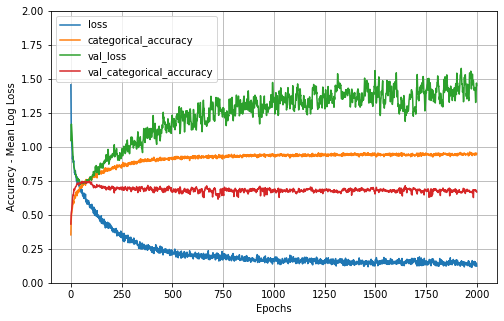

In [23]:
results=pd.DataFrame(history.history)
results.plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel ("Epochs")
plt.ylabel ("Accuracy - Mean Log Loss")
plt.gca().set_ylim(0, 2) # set the vertical range to [0-1]
plt.show()

# categorical_accuracy es el training accuracy
# val_categorical_accuracy es el validation accuracy
# loss es el training loss
# val_loss es el validation loss

# Overfitting:
# Por un lado la Accuracy de los datos de entrenamiento aumenta con las epochs,
# mientras que la Accuracy de los datos de validación disminuye o se mantiene constante a lo largo de las epochs. 
# La Loss de los datos de validación alcanza su mínimo después de pocos epochs y luego empieza a subir, 
# mientras que la Loss de los datos de entrenamiento disminuye linealmente.

In [24]:
history.params

{'verbose': 1, 'epochs': 2000, 'steps': 8}

In [25]:
results[-1:]

,loss,categorical_accuracy,val_loss,val_categorical_accuracy
1999,0.122728,0.95264,1.451598,0.668103


In [26]:
print ("Accuracy for the training set: ", results.categorical_accuracy.values[-1:][0])

Accuracy for the training set:  0.952640175819397


In [27]:
print ("Accuracy for the development test set: ", results.val_categorical_accuracy.values[-1:][0])

Accuracy for the development test set:  0.6681034564971924


#### Let's see how the model predicts using the development test set:

In [28]:
dev_predictions=model.predict(X_dev).round(2) 
dev_predictions[:20]

array([[0.44, 0.51, 0.05],
       [0.06, 0.25, 0.69],
       [0.92, 0.02, 0.06],
       [0.2 , 0.61, 0.18],
       [0.07, 0.92, 0.01],
       [0.04, 0.54, 0.42],
       [0.04, 0.79, 0.17],
       [0.  , 0.8 , 0.2 ],
       [0.  , 0.09, 0.91],
       [0.  , 0.  , 1.  ],
       [0.  , 0.01, 0.99],
       [0.  , 0.37, 0.63],
       [0.09, 0.91, 0.01],
       [0.  , 0.99, 0.  ],
       [0.01, 0.97, 0.02],
       [0.01, 0.24, 0.76],
       [0.23, 0.76, 0.02],
       [0.  , 0.99, 0.01],
       [0.  , 1.  , 0.  ],
       [0.  , 0.99, 0.01]], dtype=float32)

In [29]:
dev_rounded_predictions=np.round(dev_predictions)
indices = np.argmax(dev_predictions,1)
for row, index in zip(dev_rounded_predictions, indices): row[index]=1
dev_rounded_predictions[:20]

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [30]:
y_dev[:20]

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [31]:
dev_correct_predictions = np.equal(np.argmax(dev_rounded_predictions,1),np.argmax(y_dev,1))
print (dev_correct_predictions[:30])

[ True False False  True  True  True  True  True False False False False
  True  True  True False  True  True  True  True  True  True False  True
 False  True  True  True  True  True]


In [32]:
from collections import Counter
Counter (dev_correct_predictions)

Counter({True: 620, False: 308})

### 9. Save model

We save the model if it is better than others 

In [30]:
# Save
model.save('./Modelos/EGG_prac1_ANN_model3.h5') # Change the name in each model

In [34]:
# Extract
"""
new_model = keras.models.load_model('./Modelos/EGG_prac1_ANN_model3.h5')

import numpy as np

# Verify state
new_predictions = new_model.predict(X_dev)
np.testing.assert_allclose(predictions, new_predictions, rtol=1e-6, atol=1e-6)

# Note that the optimizer state is also preserved:
# you can resume training where you left off.
"""

"\nnew_model = keras.models.load_model('./Modelos/EGG_prac1_ANN_model3.h5')\n\nimport numpy as np\n\n# Verify state\nnew_predictions = new_model.predict(X_dev)\nnp.testing.assert_allclose(predictions, new_predictions, rtol=1e-6, atol=1e-6)\n\n# Note that the optimizer state is also preserved:\n# you can resume training where you left off.\n"

### 10 - Final Test

#### 10.1 - Load the final test set

In [35]:

"""
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Perceptron

total_records = 4 # CAMBIAR SI HAY MAS REGISTROS

task1 = 122 # SE PUEDE CAMBIAR
task2 = 123 # SE PUEDE CAMBIAR
task3 = 127 # SE PUEDE CAMBIAR
users = ["0091"] # SE PUEDE CAMBIAR
"""

In [36]:
"""
def readRegisterAndReturnXy(user, total_records, task1, task2, task3 = ""):
    lTaskData = []
    for i_rec in range(1,total_records+1):
            record = "userS"+user+"f"+str(i_rec)+".mat"
            output = read_outputs(record) # output.task será y, output.data será x

            if task3 != "":
                outT = (output.task == task1) | (output.task == task2) | (output.task == task3) 
            else: 
                outT = (output.task == task1) | (output.task == task2)
            outData = output.data[outT[:,0],0:np.shape(output.data)[1]]

            outTask = output.task[outT[:,0]]
            outTD = OutTaskData(outTask, outData)
            lTaskData.append(outTD)

    X_test, y_test = [],[]
    for j in range(0,total_records):
        X_test.extend(lTaskData[j].data)
        y_test.extend(lTaskData[j].task)

    X_test = np.array(X_test)
    y_test = np.ravel(np.array(y_test))

    print ("X_test:",X_test.shape)
    print ("y_test:",y_test.shape)

    # ONE HOT ENCODER
    encoder = make_pipeline(StandardScaler(), OneHotEncoder(categories="auto", sparse=False)) # Function that one-hot encodes integers))
    y_test = encoder.fit_transform (y_test.reshape(-1,1)) # y_one_hot

    print("ONE HOT ENCODER:")
    print ("X_test:",X_test.shape)
    print ("y_test:",y_test.shape)
    
    return X_test, y_test
"""

In [37]:
"""
n_final_test = n_instances-n_train-n_dev

x_final_test = attributes.values[n_train+n_dev:n_instances]
t_final_test = label.values[n_train+n_dev:n_instances]

print ("x_test:",x_final_test.shape)
print ("t_test:",t_final_test.shape)


"""

'\nn_final_test = n_instances-n_train-n_dev\n\nx_final_test = attributes.values[n_train+n_dev:n_instances]\nt_final_test = label.values[n_train+n_dev:n_instances]\n\nprint ("x_test:",x_final_test.shape)\nprint ("t_test:",t_final_test.shape)\n\n\n'

#### 10.2 - Evaluate the model

In [37]:
from collections import Counter
def predictWithModel(model, X_test, y_test, task1, task2, task3=""):
    model.evaluate(X_test, y_test)
    test_predictions = model.predict(X_test)
    test_rounded_predictions=np.round(test_predictions)
    indices = np.argmax(test_predictions,1)
    for row, index in zip(test_rounded_predictions, indices): row[index]=1
    print(test_rounded_predictions[:20])
    
    # ACCURACY:
    test_correct_predictions = np.equal(np.argmax(test_rounded_predictions,1),np.argmax(y_test,1))
    print()
    print(test_correct_predictions)
    print(type(test_correct_predictions))
    final_test_prediction_results=Counter(test_correct_predictions)
    
    success = np.mean(test_rounded_predictions == y_test)*100
    
    return final_test_prediction_results, success

In [38]:
users = ["0091"]
for u in users:   
    print("USER:", u)
    #X_test, y_test = readRegisterAndReturnXy(u, total_records, 122, 123, 127)
    accuracy, success = predictWithModel(model, X_test, y_test, 122, 123, 127)
    print(u, accuracy, success)
    print()

USER: 0091
29/29 [==============================] - 0s 1ms/step - loss: 1.5197 - categorical_accuracy: 0.6156
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]

[ True  True  True  True  True  True  True False False False  True  True
  True  True  True False  True  True  True  True  True  True False False
  True False False False  True  True  True  True  True  True  True  True
  True False False False  True  True  True False  True False False  True
  True False False False  True  True  True  True False False False False
  True  True  True  True  True  True  True False False  True  True False
 False False False  True  True  True  True False False False False False
 False False False  True False False  True False False  True False  True
  True  True  True  True False False False False  True  True Fal

In [40]:
#model.evaluate(x_final_test, t_final_test) # Un 77 es un accuracy bajo 

The outputs computed by the neural network for the final testing dataset.

In [41]:
"""
test_predictions=model.predict(x_final_test)
test_rounded_predictions=np.round(test_predictions)
indices = np.argmax(test_predictions,1)
for row, index in zip(test_rounded_predictions, indices): row[index]=1
test_rounded_predictions[:20]
"""

'\ntest_predictions=model.predict(x_final_test)\ntest_rounded_predictions=np.round(test_predictions)\nindices = np.argmax(test_predictions,1)\nfor row, index in zip(test_rounded_predictions, indices): row[index]=1\ntest_rounded_predictions[:20]\n'

The target outputs.

In [42]:
# t_final_test[:20]

The first 30 predictions. True means that the neural network correctly classifies the input vector.

In [43]:
# test_correct_predictions = np.equal(np.argmax(test_rounded_predictions,1),np.argmax(t_final_test,1))
# test_correct_predictions[:30]

#### The final test accuracy.

In [44]:
"""from collections import Counter
final_test_prediction_results=Counter(test_correct_predictions)
final_test_prediction_results"""

'from collections import Counter\nfinal_test_prediction_results=Counter(test_correct_predictions)\nfinal_test_prediction_results'

In [45]:
#final_test_prediction_results[True]/sum(final_test_prediction_results.values())